In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from datetime import datetime

# CNFDM

In [2]:
def tridiag(a, b, c, d):
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = bc[it-1]/ac[it-1]
        ac[it] = ac[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = ac
    xc[-1] = dc[-1]/ac[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/ac[il]

    return xc

In [3]:
# Official Price = 9193.47

# Parameters
S0 = 400 # reference price of underlying asset (2021/04/09)
T = 3    # Maturation of contract
cr = np.array([0.025, 0.045, 0.0675, 0.09, 0.1125, 0.135]) # Coupon rate of return on each early redemption date
K = np.array([0.98, 0.98, 0.95, 0.95, 0.90, 0.85])  # Exercise price on each early redemption date
d = np.array([0.5, 1, 1.5, 2, 2.5, 3]) # Early redemption date
B = 0.59 # Knock-In barrier level
sigma = 0.2785 # Volatility of the underlying asset
r = 0.0074 # CD 3-months Interest rate (2021/04/09)
q = 0 # Dividend

In [4]:
# Spacing
dx = S0*0.01  # chnage of 1% of current price
Nx = 400      # Number of space(S) points 
Smax = dx*Nx  # Max price of the underlying asset 
Smin = 0
pp = 50       # Number of time points in each 6 month
Nt = 6*pp     # Total number of time points (monthly frequency)
dt = T/Nt     # Time step
Rtag = 2*d*pp # Time step of early redemption date
S0tag = 0     # Node number of current price
Btag = 0      # Node number of barrier 

for j in range(1, Nx+2):
    if j*dx <= S0:
        S0tag+=1
    if j*dx <= S0*B:
        Btag+=1

In [5]:
def ELS_Onestar_CNFDM(Smin, Smax, sig, rf, D, S0, cr, K, B, T, Nx, Nt, dt, Rtag, Btag):
    
    # Computational domain
    S = np.linspace(Smin, Smax, Nx+1)
    x = S/S0
    
    u = np.zeros([Nt+1, Nx+1])
    w = np.zeros([Nt+1, Nx+1])
    
    x_h = np.arange(1, Nx)
    
    # Initial conditions
    for j in range(Nx+1):
        if x[j] > B:
            u[0][j] = (1 + cr[5])
        else:
            u[0][j] = x[j]
        if x[j] >= K[5]:
            w[0][j] = (1 + cr[5])
        else:
            w[0][j] = x[j]
    
    # Linear boundary condition
    u[1:,0] = 2*u[1:,1] - u[1:,2]
    u[1:,-1] = 2*u[1:,-2] - u[1:,-3]
    w[1:,0] = 2*w[1:,1] - w[1:,2]
    w[1:,-1] = 2*w[1:,-2] - w[1:,-3]
    
    # Coefficients of x for CNFDM and boundary condition adjusted
    a_ori = (dt/2)*(rf + (sig**2)*(x_h)**2)
    b_ori = (dt/4)*((rf-D)*x_h - (sig**2)*(x_h**2))
    c_ori = (dt/4)*(-(rf-D)*x_h - (sig**2)*(x_h**2))
    
    for n in range(1, Nt+1):
        
        # For u matrix
        a = copy.deepcopy(a_ori)
        b = copy.deepcopy(b_ori)
        c = copy.deepcopy(c_ori)
        d = np.zeros(Nx-1)
                
        for j in range(1, Nx):
            d[j-1] = -b[j-1]*u[n-1,j-1] + (1-a[j-1])*u[n-1,j] - c[j-1]*u[n-1,j+1]
                
        a[0] = a[0] + 2*b[0]
        c[0] = c[0] - b[0]
    
        a[Nx-2] = a[Nx-2] + 2*c[Nx-2]
        b[Nx-2] = b[Nx-2] - c[Nx-2]

        u[n,1:Nx] = tridiag(1+a,b[1:],c[:-1],d)

        a = copy.deepcopy(a_ori)
        b = copy.deepcopy(b_ori)
        c = copy.deepcopy(c_ori)
        d = np.zeros(Nx-1)
        
        # For w matrix
        for j in range(1, Nx):
            d[j-1] = -b[j-1]*w[n-1,j-1] + (1-a[j-1])*w[n-1,j] - c[j-1]*w[n-1,j+1]
                
        a[0] = a[0] + 2*b[0]
        c[0] = c[0] - b[0]
    
        a[Nx-2] = a[Nx-2] + 2*c[Nx-2]
        b[Nx-2] = b[Nx-2] - c[Nx-2]
        
        w[n,1:Nx] = tridiag(1+a,b[1:],c[:-1],d)
        u[n,1:Btag-1] = w[n,1:Btag-1]
                
        u[n,0] = 2*u[n,1] - u[n,2]
        u[n,-1] = 2*u[n,-2] - u[n,-3]
        w[n,0] = 2*w[n,1] - w[n,2]
        w[n,-1] = 2*w[n,-2] - w[n,-3]
        
        # Early redemption
        for j in range(5):
            if n == (Rtag[j]-1):
                dummy = int(np.ceil(S0tag*K[4-j]))
                dummy-=1
                u[n,dummy:] = 1 + cr[4-j]
                w[n,dummy:] = 1 + cr[4-j]
    
    price = u
    
    return price

In [6]:
price = ELS_Onestar_CNFDM(Smin, Smax, sigma, r, q, S0, cr, K, B, T, Nx, Nt, dt, Rtag, Btag)

In [7]:
face = 10000
print("ELS Price using CNFDM method: ", price[Nt,S0tag]*face)

ELS Price using CNFDM method:  9477.530189631447


# Greeks

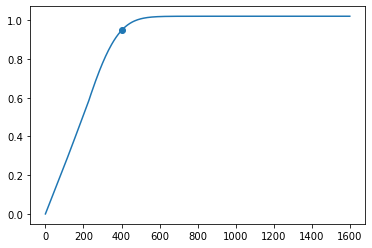

In [8]:
S = np.linspace(Smin, Smax, Nx+1)
plt.plot(S, price[Nt,:])
plt.scatter(S0, price[Nt,S0tag])
plt.show()

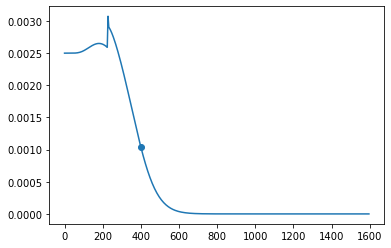

In [9]:
delta = (price[Nt,1:] - price[Nt,:-1])/dx
idx = int(S0/dx)
plt.plot(S[:-1], delta)
plt.scatter(S0, delta[idx])
plt.show()

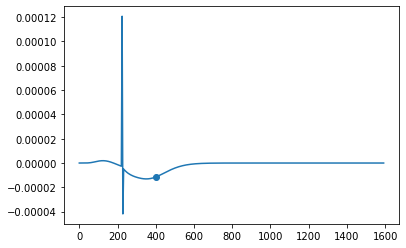

In [10]:
gamma = (delta[1:] - delta[:-1])/dx
idx = int(S0/dx)
plt.plot(S[:-2], gamma)
plt.scatter(S0, gamma[idx])
plt.show()

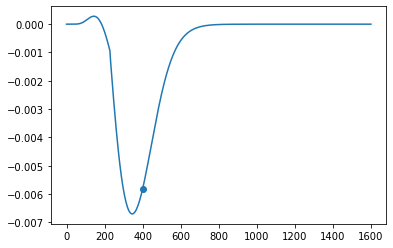

In [17]:
price_sig = ELS_Onestar_CNFDM(Smin, Smax, sigma+0.01, r, q, S0, cr, K, B, T, Nx, Nt, dt, Rtag, Btag)
vega = (price_sig[Nt,:] - price[Nt,:])/1
idx = int(S0/dx)
plt.plot(S, vega)
plt.scatter(S0, vega[idx])
plt.show()

In [18]:
print("Price : ", price[Nt,S0tag])
print("Delta : ", delta[idx])
print("Gamma : ", gamma[idx])
print("Vega : ", vega[idx])

Price :  0.9477530189631447
Delta :  0.0010419821613335267
Gamma :  -1.1496967481247622e-05
Vega :  -0.005810898192215697


# Simulation (Using Brownian Bridge)

In [13]:
def BB(w0,wt,t,m):
    h = 2**m
    T = np.linspace(0,t, h+1)
    W = np.zeros(h+1)
    z = np.random.randn(h+1)
    W[0] = w0
    W[h] = wt
    j_max = 1
    
    for k in range(1, m+1):
        i_min = h//2
        i = i_min
        l = 0
        r = h
        for j in range(1, j_max+1):
            a = ((T[r]-T[i])*W[l] + (T[i]-T[l])*W[r]) / (T[r]-T[l])
            b = np.sqrt( (T[i]-T[l])*(T[r]-T[i])/(T[r]-T[l]) )
            W[i] = a + b*z[i]
        j_max*=2
        h = i_min
    
    return W

In [14]:
def ELS_Simulation_BB(S0,r,q,sigma,T,cr,K,B,M,m):
    
    S_start = S0
    principal = 10000   
    
    check_term = 0.5
    check_max = int(T / check_term)
    
    case=8
    S = np.zeros(check_max+1)
    payment = np.zeros(M)
    prob = np.zeros(case)
    
    for i in range(M):
        
        S[0] = S_start
        
        x = np.random.randn(check_max)
        W = np.zeros(check_max+1)

        check_barrier = False
        
        for j in range(1, check_max+1):

            # Random walk
            W[j] = W[j-1] + np.sqrt(check_term) * x[j-1]            
            e =  W[j] - W[j-1]
    
            S[j] = S[j-1]*np.exp( (r - q - (sigma**2)/2)*check_term + sigma*e)
            
            # Check Barrier
            if S[j] < S_start * B:
                check_barrier = True
            
            # Check early redemption
            if S[j] >= S_start * K[j-1]:
                payment[i] = principal * (1+cr[j-1]) * np.exp(-r * j * check_term)
                prob[j-1]+=1
                break
            
            # Check Maturity redemption
            if j == check_max:
                if (check_barrier == True) and (S[j] < S_start * K[j-1]):
                    payment[i] = principal * S[j]/S_start * np.exp(-r * j * check_term)
                    prob[j+1]+=1
                    break
                    
                else:
                    S_BB = np.zeros(2**m+1)
                    S_BB[0] = S_start
                    
                    # Brownian Bridge
                    for k in range(1, check_max+1):      
                        W_BB = BB(W[k-1], W[k], 0.5, m)
                        
                        for l in range(1, 2**m+1):
                            e = W_BB[l] - W_BB[l-1]
                        
                            S_BB[l] = S_BB[l-1] * np.exp( (r - q - sigma**2/2)*(check_term/2**m) + sigma * e )
                        
                            if(S_BB[l] < S_start * B):
                                check_barrier = True
                                payment[i] = principal * S[j]/S_start * np.exp(-r * j * check_term)
                                prob[j+1]+=1
                                break
                                
                        if check_barrier:
                            break          
                        else:        
                            S_BB[0] = S_BB[2**m]
                    
                    if check_barrier == False:
                        payment[i] = principal * (1+cr[j-1]) * np.exp(-r * j * check_term)
                        prob[j]+=1
                        break
            
    
    value = np.mean(payment)
    prob = prob / M
    
    return value,prob

In [15]:
M=10000
m=3
t1=datetime.now()
value,prob=ELS_Simulation_BB(S0,r,q,sigma,T,cr,K,B,M,m)
t2=datetime.now()
print('Simulation Price = {:f}'.format(value))
for i in range(8):
    print('prob[{:d}] = {:{width}.2%}'.format(i+1,prob[i],width=6))
print('Total sum of prob = {:.0%}'.format(sum(prob)))
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Simulation Price = 9489.259950
prob[1] = 50.94%
prob[2] = 11.28%
prob[3] =  6.79%
prob[4] =  3.47%
prob[5] =  3.34%
prob[6] =  2.68%
prob[7] =  4.38%
prob[8] = 17.12%
Total sum of prob = 100%
Total computing time = 0.420873 seconds
